<a href="https://colab.research.google.com/github/zjzsu2000/CMPE297_Sec49AdvanceDL/blob/master/Assignment%202/Assignment_2_c).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment_2_c) Write a colab to demonstrate  using the mixup, label smoothing, cutout  and test time augmentation

## Load DataSet

This colob will use the CIFAR10 dataste:
   There are 60,000 32×32-pixel color images in 10 classes
https://www.cs.toronto.edu/~kriz/cifar.html

There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.
	

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

In [1]:
!pip install -U fastai

Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (2.0.13)


In [3]:
from fastai.vision.all import *

In [4]:
data_path = untar_data(URLs.CIFAR)

###getting  dataset into a `DataLoaders` object

In [5]:
from fastai.vision.data import *

In [6]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()), get_items=get_image_files,
                   get_y=parent_label,item_tfms=Resize(460), batch_tfms=aug_transforms(size=224, min_scale=0.75))


In [7]:
dataloaders = dblock.dataloaders(data_path, bs=64)

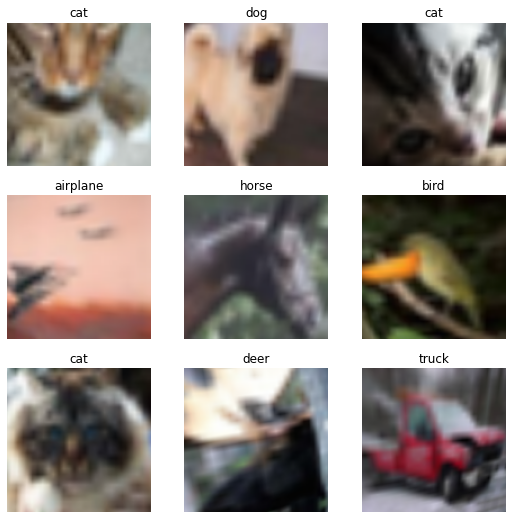

In [22]:
dataloaders.show_batch()

## Baseline:

In [16]:
model = xresnet50()

In [9]:
learn = Learner(dataloaders, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 0.003)

epoch,train_loss,valid_loss,accuracy,time
0,1.438296,1.583302,0.464917,04:33
1,1.020499,1.757478,0.473250,04:33
2,0.804701,0.773067,0.723667,04:32
3,0.639091,0.588064,0.796667,04:34
4,0.544117,0.495802,0.825000,04:33


## Normalization

In [8]:
x,y = dataloaders.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.4979, 0.4797, 0.4500], device='cuda:0'),
 TensorImage([0.2451, 0.2407, 0.2621], device='cuda:0'))

In [9]:
def get_dataloaders(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), get_items=get_image_files,
                   get_y=parent_label, item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(data_path, bs=bs)

In [10]:
dataloaders = get_dataloaders(64, 224)

In [11]:
x,y = dataloaders.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([-0.1682, -0.0307,  0.0807], device='cuda:0'),
 TensorImage([1.0933, 1.0890, 1.1746], device='cuda:0'))

In [ ]:
model = xresnet50()
learn = Learner(dataloaders, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 0.03)

## Progressive Resizing

In [12]:
dataloaders = get_dataloaders(128, 128)
learn = Learner(dataloaders, xresnet50(), loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy)
learn.fit_one_cycle(4, 0.003)

epoch,train_loss,valid_loss,accuracy,time
0,1.377112,1.760713,0.427750,02:11
1,0.948362,1.077932,0.622417,02:11
2,0.660040,0.617849,0.783667,02:12
3,0.515152,0.493564,0.829417,02:10


In [13]:
learn.dls = get_dataloaders(64, 224)
learn.fine_tune(5, 0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.673633,0.737802,0.744750,03:33


epoch,train_loss,valid_loss,accuracy,time
0,0.524660,0.516604,0.820583,03:31
1,0.525093,0.464889,0.838167,03:31
2,0.415612,0.402335,0.863083,03:32
3,0.361741,0.331104,0.886917,03:32
4,0.326391,0.316009,0.890000,03:31


## Test Time Augmentation

In [14]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.8985000252723694

## Mixup

refs:

*   https://arxiv.org/pdf/1710.09412.pdf
*   https://en.wikipedia.org/wiki/List_of_mathematical_symbols

*   http://detexify.kirelabs.org/classify.html




In [25]:
def cutout(x, n_holes=1, length=40):   
    h,w = x.shape[1:]
    for n in range(n_holes):
        h_y = np.random.randint(0, h)
        h_x = np.random.randint(0, w)
        y1 = int(np.clip(h_y - length / 2, 0, h))
        y2 = int(np.clip(h_y + length / 2, 0, h))
        x1 = int(np.clip(h_x - length / 2, 0, w))
        x2 = int(np.clip(h_x + length / 2, 0, w))
        x[:, y1:y2, x1:x2] = 1
    return x

In [20]:
model = xresnet50()
learn = Learner(dataloaders, model, loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=Mixup)
learn.fit_one_cycle(5, 0.003)

NameError: ignored

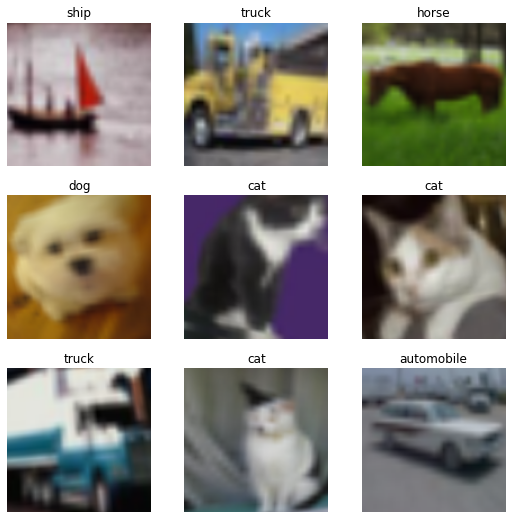

In [ ]:
!ls data_path/'train'

In [ ]:
pic1 = PILImage.create(get_image_files_sorted(data_path/'train'/'n03028079')[0])
pic2 = PILImage.create(get_image_files_sorted(data_path/'train'/'n03425413')[0])
pic1 = pic1.resize((256,256))
pic2 = pic2.resize((256,256))
t_pic1 = tensor(pic1).float() / 255.
t_pic2 = tensor(pic2).float() / 255.

_,axs = plt.subplots(1, 3, figsize=(12,4))
show_image(pic1, ax=axs[0]);
show_image(pic2, ax=axs[1]);
show_image((0.3*pic1 + 0.7*pic2), ax=axs[2]);

## Label Smoothing

In [ ]:
model = xresnet50()
learn = Learner(dataloaders, model, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
learn.fit_one_cycle(5, 0.003)

epoch,train_loss,valid_loss,accuracy,time


## Conclusion

Training longer with Mixup and/or label smoothing avoids overfitting and gives better results. 